In [22]:
import sqlite3, json
import pandas as pd

# 1. Connect to the database
conn = sqlite3.connect('../valorant_esports.db')

series_q =  "SELECT * FROM series"
series_table = pd.read_sql_query(series_q, conn)
conn.close()

ids = series_table['series_id'].values.tolist()

In [23]:
len(ids)

212

In [24]:
series_ids = ids[151:]
series_ids[:5]

['2775976', '2775977', '2775978', '2775979', '2775980']

In [ ]:
import time
import requests, json
import pandas as pd

url = "https://api-op.grid.gg/live-data-feed/series-state/graphql"
headers = {"x-api-key": ""}

series_query = """query GetLiveValorantSeriesState($id: ID!) {
  seriesState(id: $id) {
    id
    valid
    updatedAt
    format
    started
    finished    
    teams {
      id
      name
      won
      kills
      score
      killAssistsReceived
      killAssistsGiven
      selfkills 
      structuresCaptured 
      structuresDestroyed
      weaponKills{
        id
        weaponName
        count
      }
      teamkills
      teamkillAssistsReceived
      deaths      
      
      multikills{
        id
        numberOfKills
        count
      }
      players{
        ...seriesPlayerStateValorant
      }
    }
  
  }
}

fragment seriesPlayerStateValorant on SeriesPlayerStateValorant {
        id
        name
          participationStatus
        kills
        killAssistsReceived
        killAssistsGiven
  teamkills
  weaponKills{
    id
    weaponName
    count
  }
        objectives{
          type
          id
        }
          headshots
          teamHeadshots
          structuresCaptured
          structuresDestroyed
          
        }
"""

# series_ids = [2819695,2843069, 2843067, 2843063, 2843070, 2819700, 2843071, 2843068, 2843061, 2819704, 2843066,2843060, 2843062, 2819694, 2843064, 2819703, 2819701, 2819698,2843065 , 2819696, 2819699, 2819705]
def fetch_and_save_series(ids):
    with open("all_series.json", "a") as f:  # "a" for append mode
        for sid in ids:
            print(f"Fetching Series: {sid}...")
            
            # 2. Pass the ID into the 'variables' dictionary
            payload = {
                "query": series_query,
                "variables": {"id": sid}
            }
            
            response = requests.post(url, json=payload, headers=headers)
            
            if response.status_code == 200:
                data = response.json()['data']['seriesState']
                # 3. Append to file as a single line (NDJSON style)
                f.write(json.dumps(data) + "\n")
            else:
                print(f"Error on {sid}: {response.status_code}")
            time.sleep(0.5)

fetch_and_save_series(series_ids)

Fetching Series: 2775976...


KeyboardInterrupt: 

# 2819696 - 1079, 281

In [1]:
import pandas as pd
import json
jsn = pd.read_json('../200_series.json')
jsn = jsn.drop(columns=['valid','updatedAt', 'started', 'finished'])
jsn.head()

,id,format,teams
0,2653993,best-of-3,"[{'id': '97', 'name': 'NRG', 'won': False, 'ki..."
1,2653990,best-of-3,"[{'id': '96', 'name': 'G2 Esports', 'won': Tru..."
2,2653984,best-of-3,"[{'id': '96', 'name': 'G2 Esports', 'won': Tru..."
3,2681817,best-of-3,"[{'id': '281', 'name': 'Evil Geniuses', 'won':..."
4,2819696,best-of-3,"[{'id': '1079', 'name': 'Sentinels', 'won': Tr..."


In [2]:
jsn = jsn.rename(columns={'id' : 'series_id'} )
# df_teams_exploded = jsn.explode('teams')
# team_details = pd.json_normalize(df_teams_exploded['teams'])
# team_table = pd.DataFrame({'series_id': df_teams_exploded['series_id'].values, 'format': df_teams_exploded['format'].values}).join(team_details)

team_table = pd.json_normalize(
    jsn.to_dict(orient="records"),
    record_path="teams",
    meta=["series_id", "format"]
)

team_table = team_table.rename(columns={'id' : 'team_id'})
team_table = team_table.dropna()
team_table = team_table.reset_index(drop=True)

player_cols = pd.DataFrame(team_table['players'].tolist())

# 3. Rename columns to player1, player2, etc.
player_cols.columns = [f'player{i+1}' for i in range(player_cols.shape[1])]
player_cols = player_cols.reset_index(drop=True)

# Extract both 'weaponName' and 'count' as a list of dictionaries
team_table['weaponKills'] = team_table['weaponKills'].apply(
    lambda x: [
        {'weaponName': item['weaponName'], 'count': item.get('count', 0)} 
        for item in x
    ] if isinstance(x, list) else []
)
team_table['weaponKills'] = team_table['weaponKills'].apply(json.dumps)

# To use it later:
# df['weaponKills'] = df['weaponKills'].apply(json.loads) # Back to list of objects

team_table['player_ids'] = team_table['players'].apply(
    lambda x: [item['id'] for item in x] if isinstance(x, list) else []
)
team_table["player_ids"] = team_table["player_ids"].apply(lambda x: ",".join(x))

# team_table = team_table.replace({True: 1, False: 0})
team_table = team_table.drop(columns=['multikills', 'teamkillAssistsReceived','players', 'structuresDestroyed' , 'structuresCaptured' ])

# 4. Join these new columns back to the original team_table
team_table_final = pd.concat([team_table, player_cols], axis=1)
team_table_final['player1'] = team_table_final['player1'].apply(json.dumps)
team_table_final['player2'] = team_table_final['player2'].apply(json.dumps)
team_table_final['player3'] = team_table_final['player3'].apply(json.dumps)
team_table_final['player4'] = team_table_final['player4'].apply(json.dumps)
team_table_final['player5'] = team_table_final['player5'].apply(json.dumps)

team_table_final.info()
# team_final = team_table[['series_id', 'id', 'name', 'won', 'score', 'kills', 'deaths']]

<class 'pandas.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   team_id              418 non-null    str   
 1   name                 418 non-null    str   
 2   won                  418 non-null    bool  
 3   kills                418 non-null    int64 
 4   score                418 non-null    int64 
 5   killAssistsReceived  418 non-null    int64 
 6   killAssistsGiven     418 non-null    int64 
 7   selfkills            418 non-null    int64 
 8   weaponKills          418 non-null    str   
 9   teamkills            418 non-null    int64 
 10  deaths               418 non-null    int64 
 11  series_id            418 non-null    object
 12  format               418 non-null    str   
 13  player_ids           418 non-null    str   
 14  player1              418 non-null    str   
 15  player2              418 non-null    str   
 16  player3            

In [ ]:
# import pandas as pd

# from sqlalchemy import create_engine
# # 'sqlite:///filename.db' for local file
# engine = create_engine('sqlite:///valorant_esports.db')

# team_table_final.to_sql('all-teams', con=engine, if_exists='replace')

418

### All teams predictions

In [3]:
import sqlite3, json
import pandas as pd

# 1. Connect to the database
conn = sqlite3.connect('../valorant_esports.db')

# 2. Use a SQL query to fetch data directly into a DataFrame
# query = "SELECT * FROM series"
query = "SELECT * FROM 'all-teams'"
team_table_final = pd.read_sql_query(query, conn)

team_table_final['weaponKills'] = team_table_final['weaponKills'].apply(json.loads)
team_table_final['player1'] = team_table_final['player1'].apply(json.loads)
team_table_final['player2'] = team_table_final['player2'].apply(json.loads)
team_table_final['player3'] = team_table_final['player3'].apply(json.loads)
team_table_final['player4'] = team_table_final['player4'].apply(json.loads)
team_table_final['player5'] = team_table_final['player5'].apply(json.loads)

# 3. Close the connection
conn.close()

/home/ndrohith/mypc/Code/GRID/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


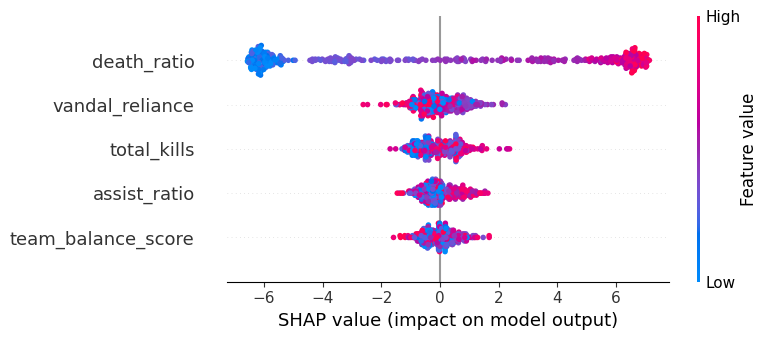

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import shap

# 1. FLATTENING FUNCTION
def extract_team_features(row):
    # Extract weapon counts
    weapons = {w['weaponName']: w['count'] for w in row['weaponKills']}
    
    # Extract individual player kills
    p_kills = [row[f'player{i}']['kills'] for i in range(1, 6) if f'player{i}' in row]
    
    return pd.Series({
        'total_kills': row['kills'],
        'death_ratio': row['kills'] / (row['deaths'] + 1),
        'vandal_reliance': weapons.get('vandal', 0) / (row['kills'] + 1),
        'team_balance_score': np.std(p_kills), # Lower is more balanced
        'assist_ratio': row['killAssistsGiven'] / (row['kills'] + 1)
    })

# 2. TRANSFORM
X = team_table_final.apply(extract_team_features, axis=1)
y = team_table_final['won'] # Target variable

# 3. TRAIN & EXPLAIN (Identifying Weaknesses)
model = XGBClassifier().fit(X, y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Visualize the 'Weaknesses' for the first team
shap.summary_plot(shap_values, X)

## Individual Team Stats

In [16]:
import numpy as np
import pandas as pd
from collections import defaultdict
import math
import shap

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def weapon_entropy(weapon_kills: dict):
    total = sum(weapon_kills.values())
    if total == 0:
        return 0
    entropy = 0
    for v in weapon_kills.values():
        p = v / total
        entropy -= p * math.log(p + 1e-9)
    return entropy

def weapon_usage_stats(weapon_kills):
    stats = {}

    if not weapon_kills:
        return {
            "most_used_weapon": None,
            "least_used_weapon": None,
            "top_weapon_ratio": 0,
            "least_weapon_ratio": 0
        }

    total_kills = sum(weapon_kills.values())

    sorted_weapons = sorted(
        weapon_kills.items(),
        key=lambda x: x[1],
        reverse=True
    )

    most_used_weapon, most_count = sorted_weapons[0]
    least_used_weapon, least_count = sorted_weapons[-1]

    stats["most_used_weapon"] = most_used_weapon
    stats["least_used_weapon"] = least_used_weapon
    stats["top_weapon_ratio"] = most_count / max(total_kills, 1)
    stats["least_weapon_ratio"] = least_count / max(total_kills, 1)
    # print("stats", stats)
    return stats

def weapon_dependency_score(weapon_kills):
    total = sum(weapon_kills.values())
    if total == 0:
        return 0
    return max(weapon_kills.values()) / total

def weapon_class_ratios(weapon_kills):
    rifle = sum(weapon_kills.get(w, 0) for w in ["phantom", "vandal", "guardian"])
    eco = sum(weapon_kills.get(w, 0) for w in ["classic", "ghost", "frenzy", "shorty", "sheriff"])
    sniper = weapon_kills.get("operator", 0)
    smg = sum(weapon_kills.get(w, 0) for w in ["stinger", "spectre"])
    shotgun = sum(weapon_kills.get(w, 0) for w in ["judge", "bucky"])

    total = sum(weapon_kills.values())

    return {
        "rifle_ratio": rifle / max(total, 1),
        "eco_ratio": eco / max(total, 1),
        "sniper_ratio": sniper / max(total, 1),
        "smg_ratio": smg / max(total, 1),
        "shotgun_ratio": shotgun / max(total, 1)
    }

# Overall won teams impact
def compute_weapon_win_impact(team_data):
    weapon_stats = defaultdict(lambda: {"wins": 0, "games": 0})

    for team in team_data:
        won = team["won"]
        for w in team["weaponKills"]:
            weapon = w["weaponName"]
            weapon_stats[weapon]["games"] += 1
            if won:
                weapon_stats[weapon]["wins"] += 1

    weapon_impact = {
        w: weapon_stats[w]["wins"] / max(weapon_stats[w]["games"], 1)
        for w in weapon_stats
    }
    # print("weapon_impact", weapon_impact)
    return weapon_impact


def extract_team_features(team_json, weapon_win_impact=None):
    features = {}

    # Basic team stats
    features['series_id'] = team_json['series_id']
    features['won'] = team_json['won']
    features['team_id'] = team_json['team_id']
    features["kills"] = team_json["kills"]
    features["deaths"] = team_json["deaths"]
    features["kill_diff"] = team_json["kills"] - team_json["deaths"]
    features["assist_density"] = team_json["killAssistsGiven"] / max(team_json["kills"], 1)
    features["assist_received_density"] = team_json["killAssistsReceived"] / max(team_json["kills"], 1)
    # features["first_kill"] = team_json["firstKill"]

    # Weapon kills (team level)
    weapon_kills = {}
    for w in team_json["weaponKills"]:
        weapon_kills[w["weaponName"]] = w["count"]

    total_weapon_kills = sum(weapon_kills.values())

    # Usage stats
    usage = weapon_usage_stats(weapon_kills)
    features.update({
        "top_weapon_ratio": usage["top_weapon_ratio"],
        "least_weapon_ratio": usage["least_weapon_ratio"],
        "weapon_dependency": weapon_dependency_score(weapon_kills),
        "weapon_entropy": weapon_entropy(weapon_kills)
    })


    # Weapon class ratios
    features.update(weapon_class_ratios(weapon_kills))

    # Weapon benefit score (weighted by kills)
    if weapon_win_impact:
        benefit = 0
        for weapon, count in weapon_kills.items():
            benefit += count * weapon_win_impact.get(weapon, 0.5)
        features["weapon_benefit_score"] = benefit / max(total_weapon_kills, 1)
    else:
        features["weapon_benefit_score"] = 0.5

    features["weapon_entropy"] = weapon_entropy(weapon_kills)

    features["rifle_ratio"] = (
        weapon_kills.get("phantom", 0) + weapon_kills.get("vandal", 0)
    ) / max(total_weapon_kills, 1)

    features["awp_dependency"] = weapon_kills.get("operator", 0) / max(total_weapon_kills, 1)
    # Player-level aggregation
    player_kills = []
    player_assists = []
    player_headshots = [] 

    for i in range(1, 6):
        p = team_json.get(f"player{i}")
        if not p:
            continue

        player_kills.append(p["kills"])
        player_assists.append(p["killAssistsGiven"])
        player_headshots.append(p.get("headshots", 0))

    features["avg_player_kills"] = np.mean(player_kills)
    features["max_player_kills"] = np.max(player_kills)
    features["std_player_kills"] = np.std(player_kills)   # star dependency
    features["team_headshot_ratio"] = sum(player_headshots) / max(sum(player_kills), 1) 

    return features

def build_dataset(team_json_list):
    X = []
    y = []

    for team in team_json_list:
        features = extract_team_features(team)
        X.append(features)
        y.append(team["won"])   # LABEL

    return pd.DataFrame(X), np.array(y)

def build_predict_structure(data_json):
    X = []
    features = extract_team_features(data_json)
    X.append(features)
    return pd.DataFrame(X)

def explain_team(model, explainer, X_row):
    shap_vals = explainer.shap_values(X_row)

    impact = dict(zip(X_row.columns, shap_vals[0]))
    sorted_impact = sorted(impact.items(), key=lambda x: abs(x[1]), reverse=True)

    strengths = [f for f, v in sorted_impact if v > 0]
    weaknesses = [f for f, v in sorted_impact if v < 0]

    return strengths, weaknesses
    
def team_strength_score(model, X_row):
    win_prob = model.predict_proba(X_row)[0][1]

    consistency = 1 / (1 + X_row["std_player_kills"].values[0])
    synergy = X_row["assist_density"].values[0]

    return float(round(0.5 * win_prob + 0.3 * consistency + 0.2 * synergy, 3))


def weapon_summary_from_features(X_row):
    return {
        "rifle_ratio": float(round(X_row["rifle_ratio"].values[0], 3)),
        "eco_ratio": float(round(X_row["eco_ratio"].values[0], 3)),
        "sniper_ratio": float(round(X_row["sniper_ratio"].values[0], 3)),
        "smg_ratio": float(round(X_row["smg_ratio"].values[0], 3)),
        "shotgun_ratio": float(round(X_row["shotgun_ratio"].values[0], 3)),
        "weapon_dependency": float(round(X_row["weapon_dependency"].values[0], 3)),
        "weapon_entropy": float(round(X_row["weapon_entropy"].values[0], 3)),
        "weapon_benefit_score": float(round(X_row["weapon_benefit_score"].values[0], 3))
    }

def combat_metrics_from_features(X_row):
    return {
        "kills": int(X_row["kills"].values[0]),
        "deaths": int(X_row["deaths"].values[0]),
        "kill_diff": int(X_row["kill_diff"].values[0]),
        "headshot_ratio": float(round(X_row["team_headshot_ratio"].values[0], 3)),
    }

def teamplay_metrics_from_features(X_row):
    return {
        "assist_density": float(round(X_row["assist_density"].values[0], 3)),
        "avg_player_kills": float(round(X_row["avg_player_kills"].values[0], 2)),
        "kill_distribution_std": float(round(X_row["std_player_kills"].values[0], 2)),
    }

def explain_team_with_scores(model, explainer, X_row, top_k=None):
    """
    Returns strengths & weaknesses with SHAP scores.
    Scores reflect contribution to WIN probability.
    """

    shap_vals = explainer.shap_values(X_row)

    impact = dict(zip(X_row.columns, shap_vals[0]))

    # Sort by absolute impact
    sorted_impact = sorted(
        impact.items(), key=lambda x: abs(x[1]), reverse=True
    )

    strengths = []
    weaknesses = []

    for feature, score in sorted_impact:
        if score > 0:
            strengths.append({
                "feature": feature,
                "shap_score": float(score)
            })
        elif score < 0:
            weaknesses.append({
                "feature": feature,
                "shap_score": float(score)
            })

    if top_k:
        strengths = strengths[:top_k]
        weaknesses = weaknesses[:top_k]

    return strengths, weaknesses


def normalize_shap_scores(items):
    max_val = max(abs(i["shap_score"]) for i in items) if items else 1

    for i in items:
        i["normalized_score"] = round(abs(i["shap_score"]) / max_val, 3)

    return items

def interpret_impact(normalized_score):
    if normalized_score >= 0.7:
        return "high impact"
    elif normalized_score >= 0.4:
        return "moderate impact"
    elif normalized_score >= 0.2:
        return "low impact"
    else:
        return "negligible impact"

def feature_win_signal(normalized_score, direction):
    if direction == "positive" and normalized_score >= 0.6:
        return "strongly supports winning"
    if direction == "negative" and normalized_score >= 0.6:
        return "strongly increases loss risk"
    return "minor influence"

def explain_team_scored(model, explainer, X_row, top_k=5):
    strengths, weaknesses = explain_team_with_scores(
        model, explainer, X_row, top_k=top_k
    )

    strengths = normalize_shap_scores(strengths)
    weaknesses = normalize_shap_scores(weaknesses)

    for s in strengths:
        s["impact_level"] = interpret_impact(s["normalized_score"])
        s["direction"] = "positive"
        s["win_signal"] = feature_win_signal(s["normalized_score"], "positive")        

    for w in weaknesses:
        w["impact_level"] = interpret_impact(w["normalized_score"])
        w["direction"] = "negative"
        s["win_signal"] = feature_win_signal(s["normalized_score"], "negative")        

    return {
        "strengths": strengths,
        "weaknesses": weaknesses
    }


def generate_team_report(model, explainer, X_row):
    # --- Prediction ---
    win_prob = model.predict_proba(X_row)[0][1]

    # --- Strength score ---
    strength_score = team_strength_score(model, X_row)

    # --- SHAP explanation ---
    # shap_vals = explainer.shap_values(X_row)
    impact_report = explain_team_scored(
        model,
        explainer,
        X_row.iloc[[0]],
        # X_test.iloc[[0]],
        top_k=5
    )

    # --- Build report ---
    report = {
        "meta_data": {
        "team_id": X_row['team_id'].values[0],
        "won" : int(X_row['won'].values[0]),
        "series_id": int(X_row['series_id'].values[0])
    },
        "team_strength_score": strength_score,
        "win_probability": float(round(win_prob, 3)), 
        "strengths": impact_report['strengths'],
        "weaknesses": impact_report['weaknesses'],

        "weapon_analysis": weapon_summary_from_features(X_row),
        "combat_metrics": combat_metrics_from_features(X_row),
        "teamplay_metrics": teamplay_metrics_from_features(X_row),
        "overall_weapon_win_impact" : compute_weapon_win_impact(data)
    }

    return report
 

def get_team_df(data, team_id, series_id):
    # 1. Convert the entire list of dicts to a DataFrame once
    df = pd.DataFrame(data)
    
    # 2. Use a boolean mask to filter (Fast & Vectorized)
    # We cast team_id to string to avoid type-mismatch errors
    filtered_df = df[(df['team_id'].astype(str) == str(team_id)) & (df['series_id'].astype(str) == str(series_id))].iloc[0]
    filtered_df = build_predict_structure(filtered_df)
    return filtered_df

def get_multiple_teams_df(data, team_id):
    df = pd.DataFrame(data)
    
    filtered_df = df[df['team_id'].astype(str) == str(team_id)]
    return filtered_df


data = team_table_final.to_dict(orient="records")

X, y = build_dataset(data)  # data = list of your team JSONs

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

preds = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

team_id = 79
series_id = 2843069
team_df = get_team_df(data, team_id, series_id)
team_report = generate_team_report(model, explainer,team_df) 
from pprint import pprint
pprint(team_report)

Accuracy: 1.0
{'combat_metrics': {'deaths': 239,
                    'headshot_ratio': 0.853,
                    'kill_diff': -42,
                    'kills': 197},
 'meta_data': {'series_id': 2843069, 'team_id': '79', 'won': 0},
 'overall_weapon_win_impact': {'ares': 0.6666666666666666,
                               'bucky': 0.4418604651162791,
                               'bulldog': 0.5114503816793893,
                               'classic': 0.5036319612590799,
                               'frenzy': 0.5190839694656488,
                               'ghost': 0.4988009592326139,
                               'guardian': 0.4912718204488778,
                               'judge': 0.5032258064516129,
                               'marshal': 0.5616438356164384,
                               'melee': 0.391304347826087,
                               'odin': 0.5620437956204379,
                               'operator': 0.504424778761062,
                               'outlaw'

In [ ]:
#  Monte Carlo Training data
import json

team_id = 79
def get_team_df(data, team_id):
    df = pd.DataFrame(data)
    
    team_reports = []
    for index, row in df.iterrows():
        row = build_predict_structure(row)
        team_report = generate_team_report(model, explainer, row)
        team_reports.append(team_report)
    return team_reports

# team_id = 79
team_reports = get_team_df(data, team_id)
team_reports_df = pd.DataFrame(team_reports)

with open('team_train_data_monte.json', 'w') as f:
    json.dump(team_reports, f, indent=4)

team_reports_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   meta_data                  418 non-null    object 
 1   team_strength_score        418 non-null    float64
 2   win_probability            418 non-null    float64
 3   strengths                  418 non-null    object 
 4   weaknesses                 418 non-null    object 
 5   weapon_analysis            418 non-null    object 
 6   combat_metrics             418 non-null    object 
 7   teamplay_metrics           418 non-null    object 
 8   overall_weapon_win_impact  418 non-null    object 
dtypes: float64(2), object(7)
memory usage: 29.5+ KB


## Overall Team

In [6]:
from collections import defaultdict
import numpy as np

def aggregate_numeric(series_reports):
    # Temporary storage for all values
    agg = {
        "general": defaultdict(list),
        "combat_metrics": defaultdict(list),
        "teamplay_metrics": defaultdict(list),
        "weapon_analysis": defaultdict(list)
    }

    for r in series_reports:
        # General top-level stats 

        # Grouped metrics
        for category in ["combat_metrics", "teamplay_metrics", "weapon_analysis"]:
            if category in r:
                for k, v in r[category].items():
                    agg[category][k].append(v)

    # Final nested dictionary construction
    result = {}
    
    # Process General stats first
    for k, v in agg["general"].items():
        result[k] = round(float(np.mean(v)), 3)

    # Process Nested Metrics
    for category in ["combat_metrics", "teamplay_metrics", "weapon_analysis"]:
        result[category] = {
            k: round(float(np.mean(v)), 3) for k, v in agg[category].items()
        }

    return result

def aggregate_strengths_weaknesses(series_reports, top_k=5):
    strength_scores = defaultdict(list)
    weakness_scores = defaultdict(list)

    for r in series_reports:
        for s in r["strengths"]:
            strength_scores[s["feature"]].append(s["normalized_score"])

        for w in r["weaknesses"]:
            weakness_scores[w["feature"]].append(w["normalized_score"])

    def create_strength_dict(feature, values, direction):
        score = float(round(np.mean(values), 3))
        return {
            "feature": feature,
            "direction": direction,
            "normalized_score": score,
            "impact_level": interpret_impact(score),
            "win_signal": feature_win_signal(score, direction)
        }

    strengths = sorted(
        [create_strength_dict(f, v, "positive") for f, v in strength_scores.items()],
        key=lambda x: x["normalized_score"],
        reverse=True
    )

    weaknesses = sorted(
            [create_strength_dict(f, v, "negative") for f, v in weakness_scores.items()],
            key=lambda x: x["normalized_score"],
            reverse=True
        )

    return strengths[:top_k], weaknesses[:top_k]

def aggregate_weapon_impact(series_reports):
    weapon_scores = defaultdict(list)

    for r in series_reports:
        for weapon, score in r.get("overall_weapon_win_impact", {}).items():
            weapon_scores[weapon].append(score)

    return {
        weapon: float(round(np.mean(scores), 3))
        for weapon, scores in weapon_scores.items()
    }
def generate_team_overall_report(team_id, series_reports):
    numeric_summary = aggregate_numeric(series_reports)
    strengths, weaknesses = aggregate_strengths_weaknesses(series_reports)
    weapon_impact = aggregate_weapon_impact(series_reports)

    return {
        "meta_data" : {
            "team_id": team_id,
            "series_count": len(series_reports),
        },
        "team_strength_score": float(round(
            np.mean([r["team_strength_score"] for r in series_reports]), 3
        )),

        "win_probability": float(round(
            np.mean([r["win_probability"] for r in series_reports]), 3
        )),

        # Extract the nested keys from numeric_summary so they sit at the top level
        "combat_metrics": numeric_summary.get("combat_metrics"),
        "teamplay_metrics": numeric_summary.get("teamplay_metrics"),
        "weapon_analysis": numeric_summary.get("weapon_analysis"),
        
        "strengths": strengths,
        "weaknesses": weaknesses,

        "overall_weapon_win_impact": weapon_impact
    }

team_id = "79"

team_df = get_multiple_teams_df(data, team_id)   # returns multiple rows (one per series)
team_df
series_reports = []
for _, row in team_df.iterrows(): 
    filtered_df = build_predict_structure(row)    
    report = generate_team_report(model, explainer, filtered_df)
    series_reports.append(report)
len(series_reports)

team_overall_report = generate_team_overall_report(
    team_id=team_id,
    series_reports=series_reports
)

from pprint import pprint
pprint(team_overall_report)
# team_id = 79
# series_id = 2843069

{'combat_metrics': {'deaths': 184.121,
                    'headshot_ratio': 0.825,
                    'kill_diff': -4.182,
                    'kills': 179.939},
 'meta_data': {'series_count': 33, 'team_id': '79'},
 'overall_weapon_win_impact': {'ares': 0.667,
                               'bucky': 0.442,
                               'bulldog': 0.511,
                               'classic': 0.504,
                               'frenzy': 0.519,
                               'ghost': 0.499,
                               'guardian': 0.491,
                               'judge': 0.503,
                               'marshal': 0.562,
                               'melee': 0.391,
                               'odin': 0.562,
                               'operator': 0.504,
                               'outlaw': 0.585,
                               'phantom': 0.501,
                               'sheriff': 0.494,
                               'shorty': 0.594,
              